<a href="https://colab.research.google.com/github/dliang5299/MIDS-207-Final-Project/blob/main/Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Model Testing

## Data Intake

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Path to data
DATA_PATH_PROC = "/content/drive/MyDrive/DATASCI 207/Final Project/NBA data - processed"

In [3]:
# Import data
odds_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_train.csv"))
odds_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_val.csv"))
odds_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_test.csv"))
X_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_train.csv"))
X_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_val.csv"))
X_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_test.csv"))
y_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_train.csv"))
y_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_val.csv"))
y_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_test.csv"))

In [4]:
# Check labels
print(y_train.columns)

Index(['spread', 'vegas_spread', 'covered_spread'], dtype='object')


In [5]:
# Drop 2012-13 data, as it does not have good previous seasons to calibrate
X_train = X_train[X_train['season'] != '2012-13']
y_train = y_train.loc[X_train.index]
odds_train = odds_train.loc[X_train.index]
print(X_train.shape)
print(y_train.shape)

(4917, 142)
(4917, 3)


In [6]:
# Drop non-numeric and ID features
X_train = X_train.drop(['season'], axis = 1)
X_val = X_val.drop(['season'], axis = 1)
X_test = X_test.drop(['season'], axis = 1)

In [7]:
# Separate actual and Vegas spreads
y_train, y_train_vegas, y_train_class = y_train['spread'], y_train['vegas_spread'], y_train['covered_spread']
y_val, y_val_vegas, y_val_class = y_val['spread'], y_val['vegas_spread'], y_val['covered_spread']
y_test, y_test_vegas, y_test_class = y_test['spread'], y_test['vegas_spread'], y_test['covered_spread']

In [8]:
# Examine data
X_train.head()

,days_since_last_game_away,days_since_last_game_home,consecutive_away_games,pts_tot_last50_away,pts_tot_last50_home,fg_pct_last50_away,fg_pct_last50_home,ft_pct_last50_away,ft_pct_last50_home,fg3_pct_last50_away,fg3_pct_last50_home,ast_last50_away,ast_last50_home,reb_last50_away,reb_last50_home,tov_last50_away,tov_last50_home,spread_last50_away,spread_last50_home,wr_last50_away,wr_last50_home,pts_tot_last10_away,pts_tot_last10_home,fg_pct_last10_away,fg_pct_last10_home,ft_pct_last10_away,ft_pct_last10_home,fg3_pct_last10_away,fg3_pct_last10_home,ast_last10_away,ast_last10_home,reb_last10_away,reb_last10_home,tov_last10_away,tov_last10_home,spread_last10_away,spread_last10_home,wr_last10_away,wr_last10_home,pts_tot_last20_away,pts_tot_last20_home,fg_pct_last20_away,fg_pct_last20_home,ft_pct_last20_away,ft_pct_last20_home,fg3_pct_last20_away,fg3_pct_last20_home,ast_last20_away,ast_last20_home,reb_last20_away,reb_last20_home,tov_last20_away,tov_last20_home,spread_last20_away,spread_last20_home,wr_last20_away,wr_last20_home,pts_tot_last10_loc_away,pts_tot_last10_loc_home,fg_pct_last10_loc_away,fg_pct_last10_loc_home,ft_pct_last10_loc_away,ft_pct_last10_loc_home,fg3_pct_last10_loc_away,fg3_pct_last10_loc_home,ast_last10_loc_away,ast_last10_loc_home,reb_last10_loc_away,reb_last10_loc_home,tov_last10_loc_away,tov_last10_loc_home,spread_last10_loc_away,spread_last10_loc_home,wr_last10_loc_away,wr_last10_loc_home,pts_tot_last20_loc_away,pts_tot_last20_loc_home,fg_pct_last20_loc_away,fg_pct_last20_loc_home,ft_pct_last20_loc_away,ft_pct_last20_loc_home,fg3_pct_last20_loc_away,fg3_pct_last20_loc_home,ast_last20_loc_away,ast_last20_loc_home,reb_last20_loc_away,reb_last20_loc_home,tov_last20_loc_away,tov_last20_loc_home,spread_last20_loc_away,spread_last20_loc_home,wr_last20_loc_away,wr_last20_loc_home,pts_tot_last50_loc_away,pts_tot_last50_loc_home,fg_pct_last50_loc_away,fg_pct_last50_loc_home,ft_pct_last50_loc_away,ft_pct_last50_loc_home,fg3_pct_last50_loc_away,fg3_pct_last50_loc_home,ast_last50_loc_away,ast_last50_loc_home,reb_last50_loc_away,reb_last50_loc_home,tov_last50_loc_away,tov_last50_loc_home,spread_last50_loc_away,spread_last50_loc_home,wr_last50_loc_away,wr_last50_loc_home,team_abbr_home_ATL,team_abbr_home_BKN,team_abbr_home_BOS,team_abbr_home_CHA,team_abbr_home_CHI,team_abbr_home_CLE,team_abbr_home_DAL,team_abbr_home_DEN,team_abbr_home_DET,team_abbr_home_GSW,team_abbr_home_HOU,team_abbr_home_IND,team_abbr_home_LAC,team_abbr_home_LAL,team_abbr_home_MEM,team_abbr_home_MIA,team_abbr_home_MIL,team_abbr_home_MIN,team_abbr_home_NOP,team_abbr_home_NYK,team_abbr_home_OKC,team_abbr_home_ORL,team_abbr_home_PHI,team_abbr_home_PHX,team_abbr_home_POR,team_abbr_home_SAC,team_abbr_home_SAS,team_abbr_home_TOR,team_abbr_home_UTA,team_abbr_home_WAS
1187,3.444724,3.014895,-1.502148,-1.297061,-0.804159,-0.569034,-0.656483,-0.125630,-0.015211,-1.807693,-0.297349,0.614268,-0.897575,-0.104259,1.640293,-0.500368,0.346769,2.074874,-1.186349,-2.185387,0.767726,-1.567411,-0.689130,-1.263968,-0.178655,-1.240278,-0.692122,-1.295693,-1.701479,-0.494278,-1.127795,1.367726,-0.081138,-0.174011,0.289596,1.394564,0.297100,-1.395332,0.003895,-1.452281,-0.552614,-1.153942,-0.572884,-1.033084,0.110651,-1.556177,-0.847687,-0.708154,-0.856917,0.358053,1.303860,-0.363732,0.122547,1.880324,-0.662982,-1.939624,0.276467,-1.334685,-1.144433,-0.693828,-1.184832,-0.856553,-0.196131,-2.191266,-1.877645,-0.464368,-1.982204,1.034923,1.282190,-0.895257,0.159469,1.230613,0.008864,-2.044296,-0.379797,-1.368669,-0.294401,-0.482798,-0.454448,-0.647803,-0.470356,-2.962086,-0.336369,0.474603,-1.030229,0.929656,1.204107,-0.862059,0.140169,1.127141,-0.807570,-1.818237,0.106082,-1.207329,-0.700922,-0.266241,-1.096674,0.538637,-0.344916,-3.100866,0.660305,1.019283,-1.225833,0.724141,2.073265,-0.720863,-0.086937,0.961521,-1.054521,-1.444487,0.889032,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fa

## Baseline linear regression

In [9]:
# Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_val = lr_model.predict(X_val)

# Evaluate the model
mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)
mse_lr_val = mean_squared_error(y_val, y_pred_lr_val)

# Print results
print(f'Linear Regression Train Mean Squared Error: {mse_lr_train}')
print(f'Linear Regression Val Mean Squared Error: {mse_lr_val}')

Linear Regression Train Mean Squared Error: 0.7875196859625294
Linear Regression Val Mean Squared Error: 0.9208792536916501


## Random Forest

In [10]:
# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=5, max_depth=4, random_state=1234)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_val = rf_model.predict(X_val)

# Evaluate the model
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
mse_rf_val = mean_squared_error(y_val, y_pred_rf_val)

# Print results
print(f'Random Forest Train Mean Squared Error: {mse_rf_train}')
print(f'Random Forest Val Mean Squared Error: {mse_rf_val}')

Random Forest Train Mean Squared Error: 0.7796288177402066
Random Forest Val Mean Squared Error: 0.8710501849952723


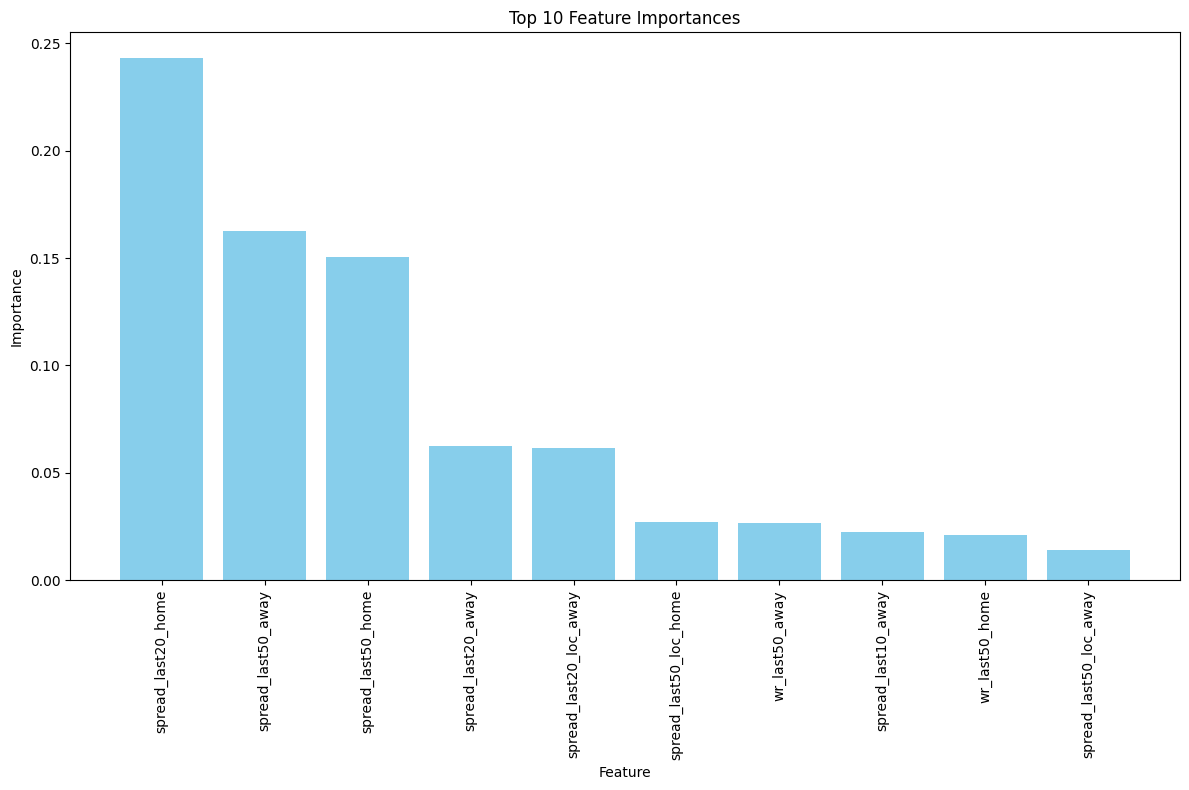

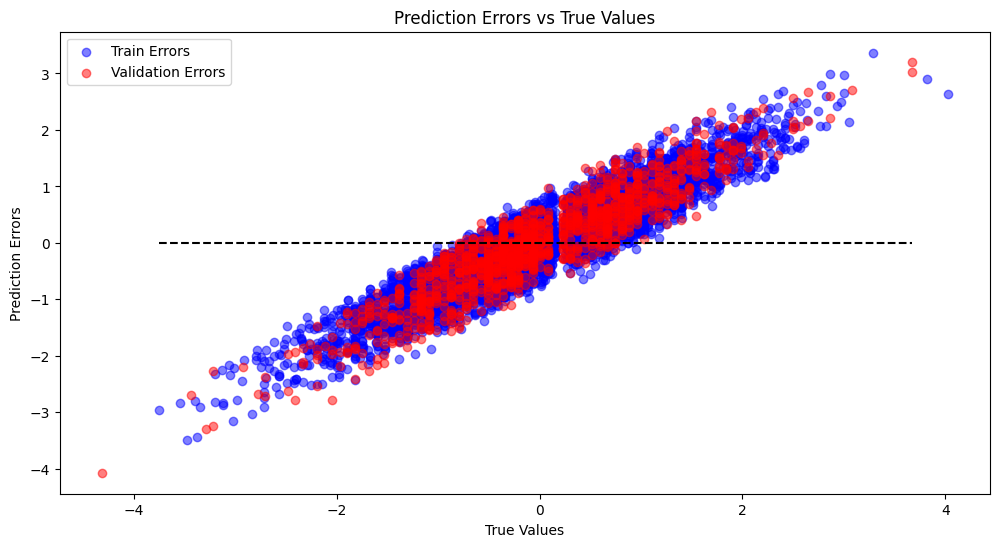

In [11]:
# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:10]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Top 10 Feature Importances')
plt.bar(range(10), importances[top_indices], align='center', color='skyblue')
plt.xticks(range(10), [X_train.columns[i] for i in top_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Errors plot
errors_train = y_train - y_pred_rf_train
errors_val = y_val - y_pred_rf_val

plt.figure(figsize=(12, 6))
plt.scatter(y_train, errors_train, color='blue', label='Train Errors', alpha=0.5)
plt.scatter(y_val, errors_val, color='red', label='Validation Errors', alpha=0.5)
plt.hlines(0, min(y_train), max(y_val), colors='k', linestyles='dashed')
plt.xlabel('True Values')
plt.ylabel('Prediction Errors')
plt.title('Prediction Errors vs True Values')
plt.legend()
plt.show()

## Neural Network

### Regression

In [12]:
# Define the function to create the Keras model
def create_model(params):
    '''Build a regression NN model
    Parameters:
    params (dict): This is a dictionary of parameters for the model

    Returns:
    model: Compiled TF model
    '''
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(int(params['units1']), activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(int(params['units2']), activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))  # Output layer for classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Define the objective function
def objective(params):
    '''Fit a model
    Parameters:
    params (dict): This is a dictionary of parameters for the model

    Returns:
    result: Final loss and status of fit
    '''
    model = create_model(params)
    model_fit = model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0,
              validation_data=(X_val, y_val))
    loss = model_fit.history['val_loss'][-1]
    result = {'loss': loss, 'status': STATUS_OK}

    return result

In [13]:
# Define hyperparameter space
space = {
    'units1': hp.quniform('units1', 10, 300, 10),
    'units2': hp.quniform('units2', 10, 200, 10),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'dropout': hp.quniform('dropout', 0, 0.5, 0.1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1))
}
trials = Trials()

# Hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best parameters:", best)

100%|██████████| 50/50 [09:07<00:00, 10.95s/trial, best loss: 0.8716325759887695]
Best parameters: {'activation': 0, 'dropout': 0.30000000000000004, 'lr': 0.001989204479249128, 'units1': 10.0, 'units2': 20.0}


In [14]:
# Create the model with the best hyperparameters
best_params = {'units1': int(best['units1']),
               'units2': int(best['units2']),
               'activation': ['relu', 'tanh'][int(best['activation'])],
               'dropout': best['dropout'],
               'lr': best['lr']}
best_model = create_model(best_params)
best_model_fit = best_model.fit(X_train, y_train, epochs=15, batch_size=32,
                                verbose=0, validation_data=(X_val, y_val))

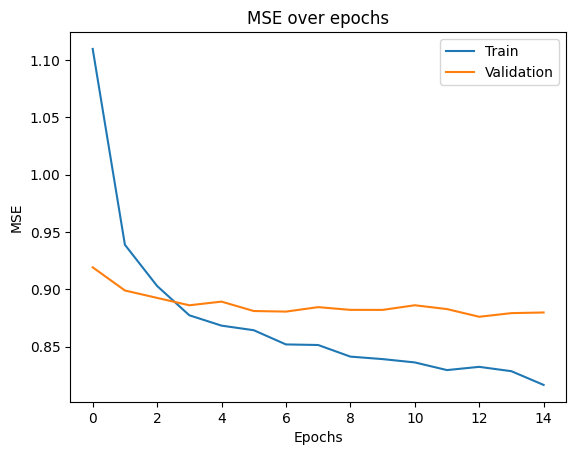

In [15]:
# Plot model performance history
fig, ax = plt.subplots()
ax.plot(best_model_fit.history['loss'])
ax.plot(best_model_fit.history['val_loss'])
ax.set_title('MSE over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.legend(['Train', 'Validation'], fontsize=10)
plt.show()

In [16]:
# Print final results
print("Training MSE:", best_model.evaluate(x = X_train, y = y_train))
print("Validation MSE:", best_model.evaluate(x = X_val, y = y_val))

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7868
Training MSE: 0.7924945950508118
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9232 
Validation MSE: 0.8798759579658508


### Classifier

In [17]:
# Display baseline performance - assumes spread is never covered
print("Baseline accuracy - train:", 100 * np.count_nonzero(y_train_class == 0) / (np.count_nonzero(y_train_class == 0) + np.count_nonzero(y_train_class == 1)), "%")
print("Baseline accuracy - val:", 100 * np.count_nonzero(y_val_class == 0) / (np.count_nonzero(y_val_class == 0) + np.count_nonzero(y_val_class == 1)), "%")

Baseline accuracy - train: 50.071181614805774 %
Baseline accuracy - val: 50.97560975609756 %


In [18]:
# Define the function to create the Keras model
def create_model(params):
    '''Build a classification NN model
    Parameters:
    params (dict): This is a dictionary of parameters for the model

    Returns:
    model: Compiled TF model
    '''
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(int(params['units1']), activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(int(params['units2']), activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the objective function
def objective(params):
    '''Fit a model
    Parameters:
    params (dict): This is a dictionary of parameters for the model

    Returns:
    result: Final loss and status of fit
    '''
    model = create_model(params)
    model_fit = model.fit(X_train, y_train_class, epochs=15, batch_size=32, verbose=0,
              validation_data=(X_val, y_val_class))
    loss = model_fit.history['val_loss'][-1]
    result = {'loss': loss, 'status': STATUS_OK}

    return result

In [26]:
# Define hyperparameter space
space = {
    'units1': hp.quniform('units1', 10, 300, 10),
    'units2': hp.quniform('units2', 10, 200, 10),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'dropout': hp.quniform('dropout', 0, 0.5, 0.1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1))
}
trials = Trials()

# Hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best parameters:", best)

100%|██████████| 50/50 [11:27<00:00, 13.75s/trial, best loss: 0.6929596066474915]
Best parameters: {'activation': 0, 'dropout': 0.0, 'lr': 0.04238475885509501, 'units1': 230.0, 'units2': 200.0}


In [38]:
# Store optimization history
history = []
for trial in trials.trials:
    history.append({
        'trial_id': trial['tid'],
        'lr': np.round(trial['misc']['vals']['lr'][0], 4),
        'units1': trial['misc']['vals']['units1'][0],
        'units2': trial['misc']['vals']['units2'][0],
        'dropout': trial['misc']['vals']['dropout'][0],
        'loss': trial['result']['loss']
    })
history_df = pd.DataFrame(history)

# Inspect history df
history_df.head()

,trial_id,lr,units1,units2,dropout,loss
0,0,0.0085,170.0,120.0,0.2,0.693888
1,1,0.0116,110.0,10.0,0.1,0.710813
2,2,0.0709,30.0,190.0,0.4,1.182741
3,3,0.0035,30.0,100.0,0.4,0.702577
4,4,0.0049,190.0,100.0,0.3,0.705322


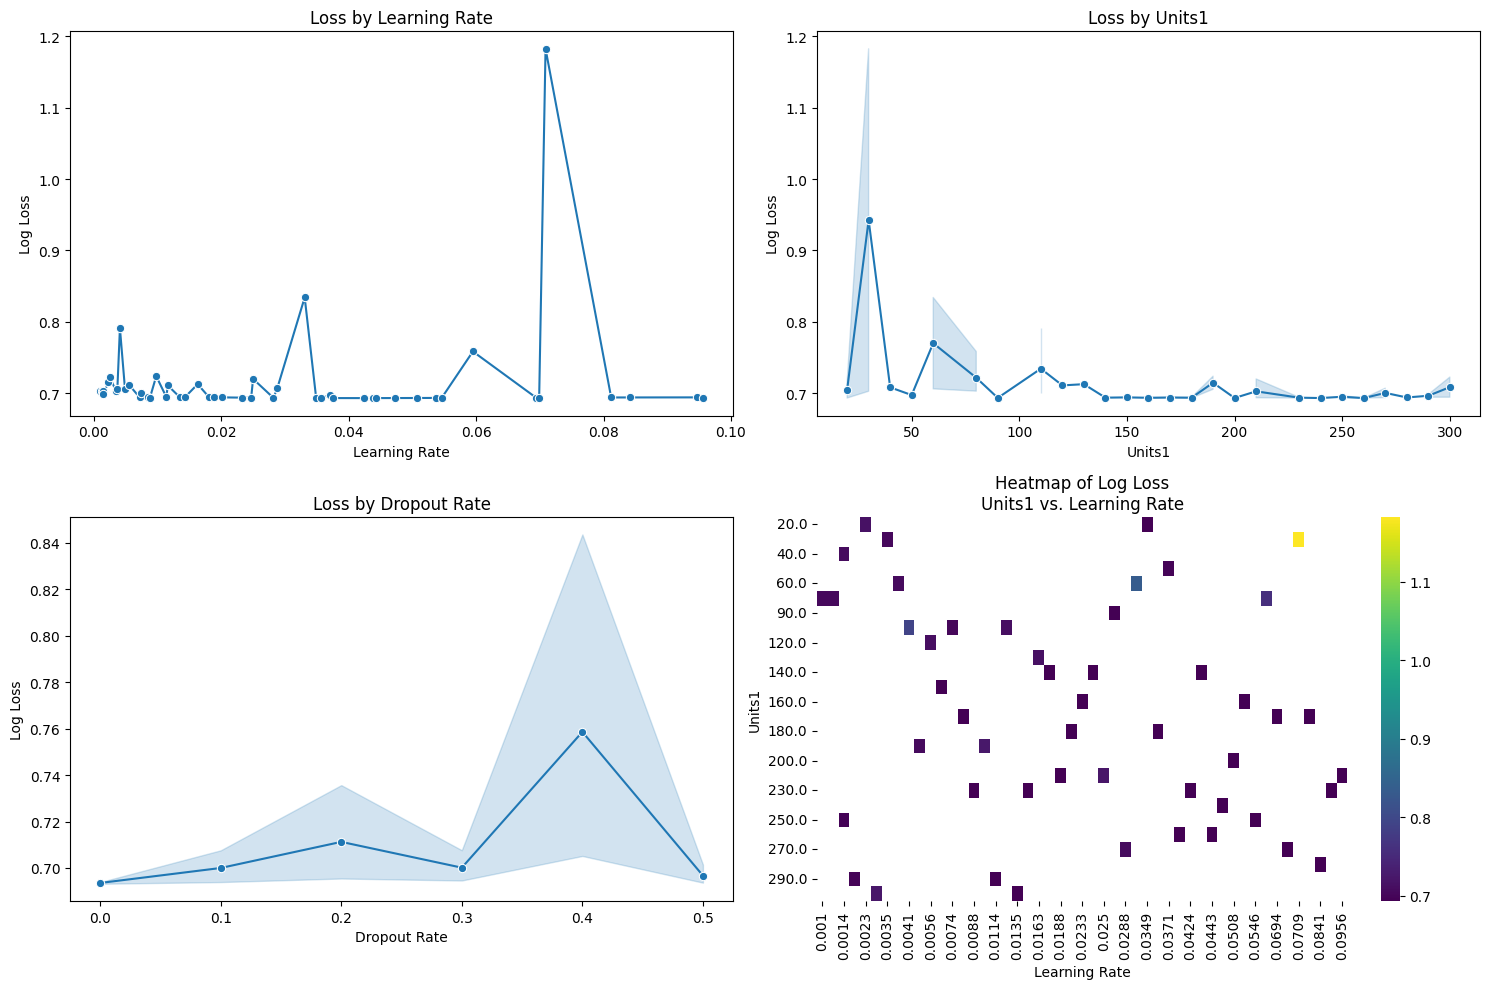

In [41]:
# Initialize experiments graph
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Validation Loss by Learning Rate
sns.lineplot(x='lr', y='loss', data=history_df.sort_values('lr'), marker='o', ax=axs[0, 0])
axs[0, 0].set_title('Loss by Learning Rate')
axs[0, 0].set_xlabel('Learning Rate')
axs[0, 0].set_ylabel('Log Loss')

# Plot 2: Validation Loss by Units1
sns.lineplot(x='units1', y='loss', data=history_df.sort_values('units1'), marker='o', ax=axs[0, 1])
axs[0, 1].set_title('Loss by Units1')
axs[0, 1].set_xlabel('Units1')
axs[0, 1].set_ylabel('Log Loss')

# Plot 3: Validation Loss by Dropout
sns.lineplot(x='dropout', y='loss', data=history_df.sort_values('dropout'), marker='o', ax=axs[1, 0])
axs[1, 0].set_title('Loss by Dropout Rate')
axs[1, 0].set_xlabel('Dropout Rate')
axs[1, 0].set_ylabel('Log Loss')

# Plot 4: Heatmap of Units1 vs. Learning Rate
# Prepare data for heatmap
heatmap_data = history_df.pivot_table(values='loss', index='units1', columns='lr', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='viridis', ax=axs[1, 1])
axs[1, 1].set_title('Heatmap of Log Loss\nUnits1 vs. Learning Rate')
axs[1, 1].set_xlabel('Learning Rate')
axs[1, 1].set_ylabel('Units1')

plt.tight_layout()
plt.show()

Best Parameters:


*   {'activation': 1, 'dropout': 0.5, 'lr': 0.01, 'units1': 230.0, 'units2': 20.0}



In [42]:
# Create the model with the best hyperparameters
best = {'activation': 1, 'dropout': 0.5, 'lr': 0.01, 'units1': 230, 'units2': 20}
best_params = {'units1': int(best['units1']),
               'units2': int(best['units2']),
               'activation': ['relu', 'tanh'][int(best['activation'])],
               'dropout': best['dropout'],
               'lr': best['lr']}
best_model = create_model(best_params)
best_model_fit = best_model.fit(X_train, y_train_class, epochs=15, batch_size=32,
                                verbose=0, validation_data=(X_val, y_val_class))

In [43]:
### DO NOT RUN ###
# Save out model
# best_model.save("/content/drive/MyDrive/DATASCI 207/Final Project/best_model.keras")

# Save out fit history
# best_model_fit_dict = best_model_fit.history
# with open("/content/drive/MyDrive/DATASCI 207/Final Project/best_model_fit.pkl", "wb") as f:
#     pickle.dump(best_model_fit_dict, f)
#################

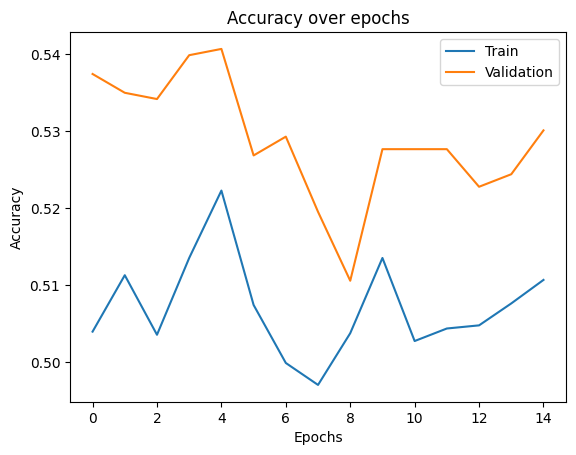

In [44]:
# Plot model performance history - accuracy
fig, ax = plt.subplots()
ax.plot(best_model_fit.history['accuracy'])
ax.plot(best_model_fit.history['val_accuracy'])
ax.set_title('Accuracy over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], fontsize=10)
plt.show()

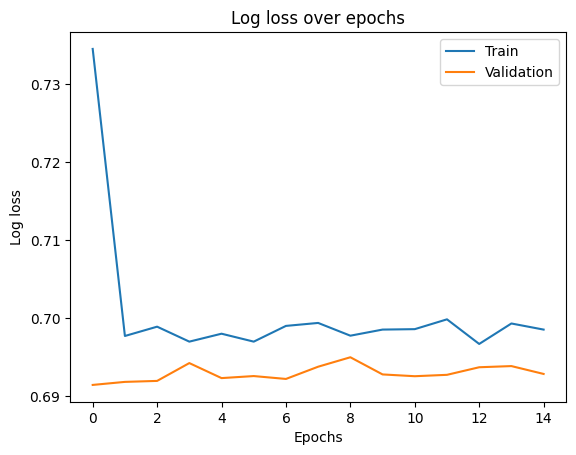

In [45]:
# Plot model performance history - loss
fig, ax = plt.subplots()
ax.plot(best_model_fit.history['loss'])
ax.plot(best_model_fit.history['val_loss'])
ax.set_title('Log loss over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Log loss')
ax.legend(['Train', 'Validation'], fontsize=10)
plt.show()

In [46]:
# Print final results
print("Training accuracy:", best_model.evaluate(x = X_train, y = y_train_class)[1])
print("Validation accuracy:", best_model.evaluate(x = X_val, y = y_val_class)[1])

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5301 - loss: 0.6938
Training accuracy: 0.5204392671585083
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5154 - loss: 0.6966
Validation accuracy: 0.5300812721252441


## Calculating returns

### Baseline return

In [47]:
# Column bind probabilities and odds
returns_base_df = pd.concat([odds_val, pd.DataFrame(y_val_class, columns = ['covered_spread'])], axis = 1)
returns_base_df['adj_win_prob'] = np.full(shape = odds_val.shape[0], fill_value = 0.5)
returns_base_df['covered_spread_bet'] = np.full(shape = odds_val.shape[0], fill_value = 1)

# Calculate adjusted win prob. based on bet
returns_base_df['kelly_wager'] = 100 * (returns_base_df['adj_win_prob'] - (1 - returns_base_df['adj_win_prob']) / returns_base_df['spread_odds'])
returns_base_df.loc[returns_base_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_base_df['return'] = returns_base_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total validation return:", returns_base_df['return'].sum())
print("Over number of games:", returns_base_df.shape[0])
print("Percent validation return:", returns_base_df['return'].sum() / returns_base_df['kelly_wager'].sum())
print("Average validation return:", returns_base_df['return'].sum()/returns_base_df.shape[0])

Total validation return: 0.0
Over number of games: 1230
Percent validation return: nan
Average validation return: 0.0


<ipython-input-47-136967a7bf58>:14: RuntimeWarning: invalid value encountered in scalar divide
  print("Percent validation return:", returns_base_df['return'].sum() / returns_base_df['kelly_wager'].sum())


### Training return

In [48]:
# Column bind probabilities and odds
y_pred_train = best_model.predict(X_train)
returns_train_df = pd.concat([odds_train, pd.DataFrame(y_pred_train, columns = ['prob']), pd.DataFrame(y_train_class, columns = ['covered_spread'])], axis = 1)
returns_train_df['covered_spread_bet'] = returns_train_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_train_df['adj_win_prob'] = returns_train_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_train_df['kelly_wager'] = 100 * (returns_train_df['adj_win_prob'] - (1 - returns_train_df['adj_win_prob']) / returns_train_df['spread_odds'])
returns_train_df.loc[returns_train_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_train_df['return'] = returns_train_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total training return:", returns_train_df['return'].sum())
print("Over number of games:", returns_train_df.shape[0])
print("Percent training return:", returns_train_df['return'].sum() / returns_train_df['kelly_wager'].sum())
print("Average training return:", returns_train_df['return'].sum()/returns_train_df.shape[0])

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total training return: 9702.882795214558
Over number of games: 6104
Percent training return: 0.43170433486463483
Average training return: 1.589594166974862


### Validation return

In [49]:
# Column bind probabilities and odds
y_pred_val = best_model.predict(X_val)
returns_val_df = pd.concat([odds_val, pd.DataFrame(y_pred_val, columns = ['prob']), pd.DataFrame(y_val_class, columns = ['covered_spread'])], axis = 1)
returns_val_df['covered_spread_bet'] = returns_val_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_val_df['adj_win_prob'] = returns_val_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_val_df['kelly_wager'] = 100 * (returns_val_df['adj_win_prob'] - (1 - returns_val_df['adj_win_prob']) / returns_val_df['spread_odds'])
returns_val_df.loc[returns_val_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_val_df['return'] = returns_val_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total validation return:", returns_val_df['return'].sum())
print("Over number of games:", returns_val_df.shape[0])
print("Percent validation return:", returns_val_df['return'].sum() / returns_val_df['kelly_wager'].sum())
print("Average validation return:", returns_val_df['return'].sum()/returns_val_df.shape[0])

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Total validation return: 4295.892942246528
Over number of games: 1230
Percent validation return: 0.5598100897256028
Average validation return: 3.492595888005307
